# COMP4030 - Data Science and Machine Learning - Coursework 2

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [1]:
# Ashley Hunt - psyah10
import os

def get_gestures():
      return ['circle', 'come', 'go', 'wave']

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture):
      gesture_dir = os.path.join(os.getcwd(), "data", gesture)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [2]:
# Ashley Hunt - psyah10
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## Simple function to read a csv file and return a dataframe - If scaler is provided, it will scale the data
def get_df(path, scaler=None, trim=True):
      if not path.endswith('.csv'):
            return []
      
      raw_data = pd.read_csv(path)
      raw_data.columns = get_columns()

      df = pd.DataFrame(scaler.fit_transform(raw_data) if scaler else raw_data, columns=raw_data.columns)

      return trim_recording(df) if trim else df

## Function to trim the recording to the first and last significant movement
def trim_recording(df, padding=90):
      window_size = 20
      threshold = 0.3

      df['rolling_max'] = df['accel_abs'].rolling(window=window_size, min_periods=1).mean()

      start_cut = df[df['rolling_max'] >= threshold].index.min()
      if pd.notna(start_cut):
            cut_index = max(start_cut - padding, 0)
            df = df.loc[cut_index:]
      
      end_cut = df[df['rolling_max'] >= threshold].index.max()
      if pd.notna(end_cut):
            end_cut_index = min(end_cut + padding, len(df) - 1) 
            df = df.loc[:end_cut_index]

      df = df.drop('rolling_max', axis=1)
      return df

## Function to get all the data from the files in the data folder
def get_data_from_files(scaler=None):
      dfs = []
      for gesture in get_gestures():
            for file_index, file_name in enumerate(get_gesture_csvs(gesture)):
                  df = get_df(f'data/{gesture}/{file_name}', scaler)
                  if len(df) == 0:
                        continue

                  df['file_number'] = int(file_index)
                  df['file_name'] = str(file_name)
                  df['gesture'] = str(gesture)

                  dfs.append(df)

      return pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]

# scaler = StandardScaler()
scaler = MinMaxScaler()

df = get_data_from_files(scaler)
test_data = get_df(f'data/test/all.csv', scaler)
df

time   accel_x   accel_y   accel_z  accel_abs  file_number  \
0      0.048098  0.535730  0.548018  0.229814   0.039610            0   
1      0.048815  0.549592  0.545577  0.203769   0.057488            0   
2      0.049533  0.547687  0.562679  0.216363   0.045317            0   
3      0.050251  0.548894  0.566675  0.239260   0.048563            0   
4      0.050969  0.548961  0.573507  0.237559   0.049097            0   
...         ...       ...       ...       ...        ...          ...   
49339  0.983442  0.516840  0.898125  0.596165   0.009438            9   
49340  0.984033  0.517999  0.902521  0.597518   0.007391            9   
49341  0.984624  0.520665  0.905240  0.598694   0.005232            9   
49342  0.985216  0.523374  0.909225  0.600580   0.006959            9   
49343  0.985807  0.523479  0.914794  0.599140   0.006162            9   

       file_name gesture  
0          1.csv  circle  
1          1.csv  circle  
2          1.csv  circle  
3          1.csv  circle  
4          1.csv  circle  
...          ...     ...  
49339  wave5.csv    wave  
49340  wave5.csv    wave  
49341  wave5.csv    wave  
49342  wave5.csv    wave  
49343  wave5.csv    wave  

[49344 rows x 8 columns]

In [3]:
test_data

time   accel_x   accel_y   accel_z  accel_abs
406  0.298565  0.432063  0.647936  0.487325   0.008644
407  0.299301  0.427760  0.646511  0.487571   0.012463
408  0.300037  0.428220  0.646115  0.485869   0.011945
409  0.300773  0.436224  0.649645  0.481306   0.008588
410  0.301509  0.440628  0.653657  0.478124   0.012828
..        ...       ...       ...       ...        ...
939  0.698308  0.469577  0.680729  0.487393   0.040622
940  0.699043  0.471150  0.681148  0.491277   0.043153
941  0.699780  0.474652  0.687884  0.488075   0.049283
942  0.700516  0.474421  0.693195  0.489855   0.053312
943  0.701252  0.468601  0.692748  0.490712   0.049533

[538 rows x 5 columns]

Next we apply a low-pass filter to reduce noise from the data and make our model more robust

In [4]:
# Ashley Hunt - psyah10
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [5]:
# Ashley Hunt - psyah10

# Filter parameters
cutoff_frequency = 4  # Cutoff frequency in Hz - Higher = less smoothing
sampling_rate = 50  # Sampling rate in Hz - Higher = more smoothing
filter_order = 10  # Filter order - Higher = less smoothing

for column in get_columns()[1:]:
    df[column] = butter_lowpass_filter(df[column], cutoff_frequency, sampling_rate, filter_order)

Next we visualise our raw data for exploratory analysis

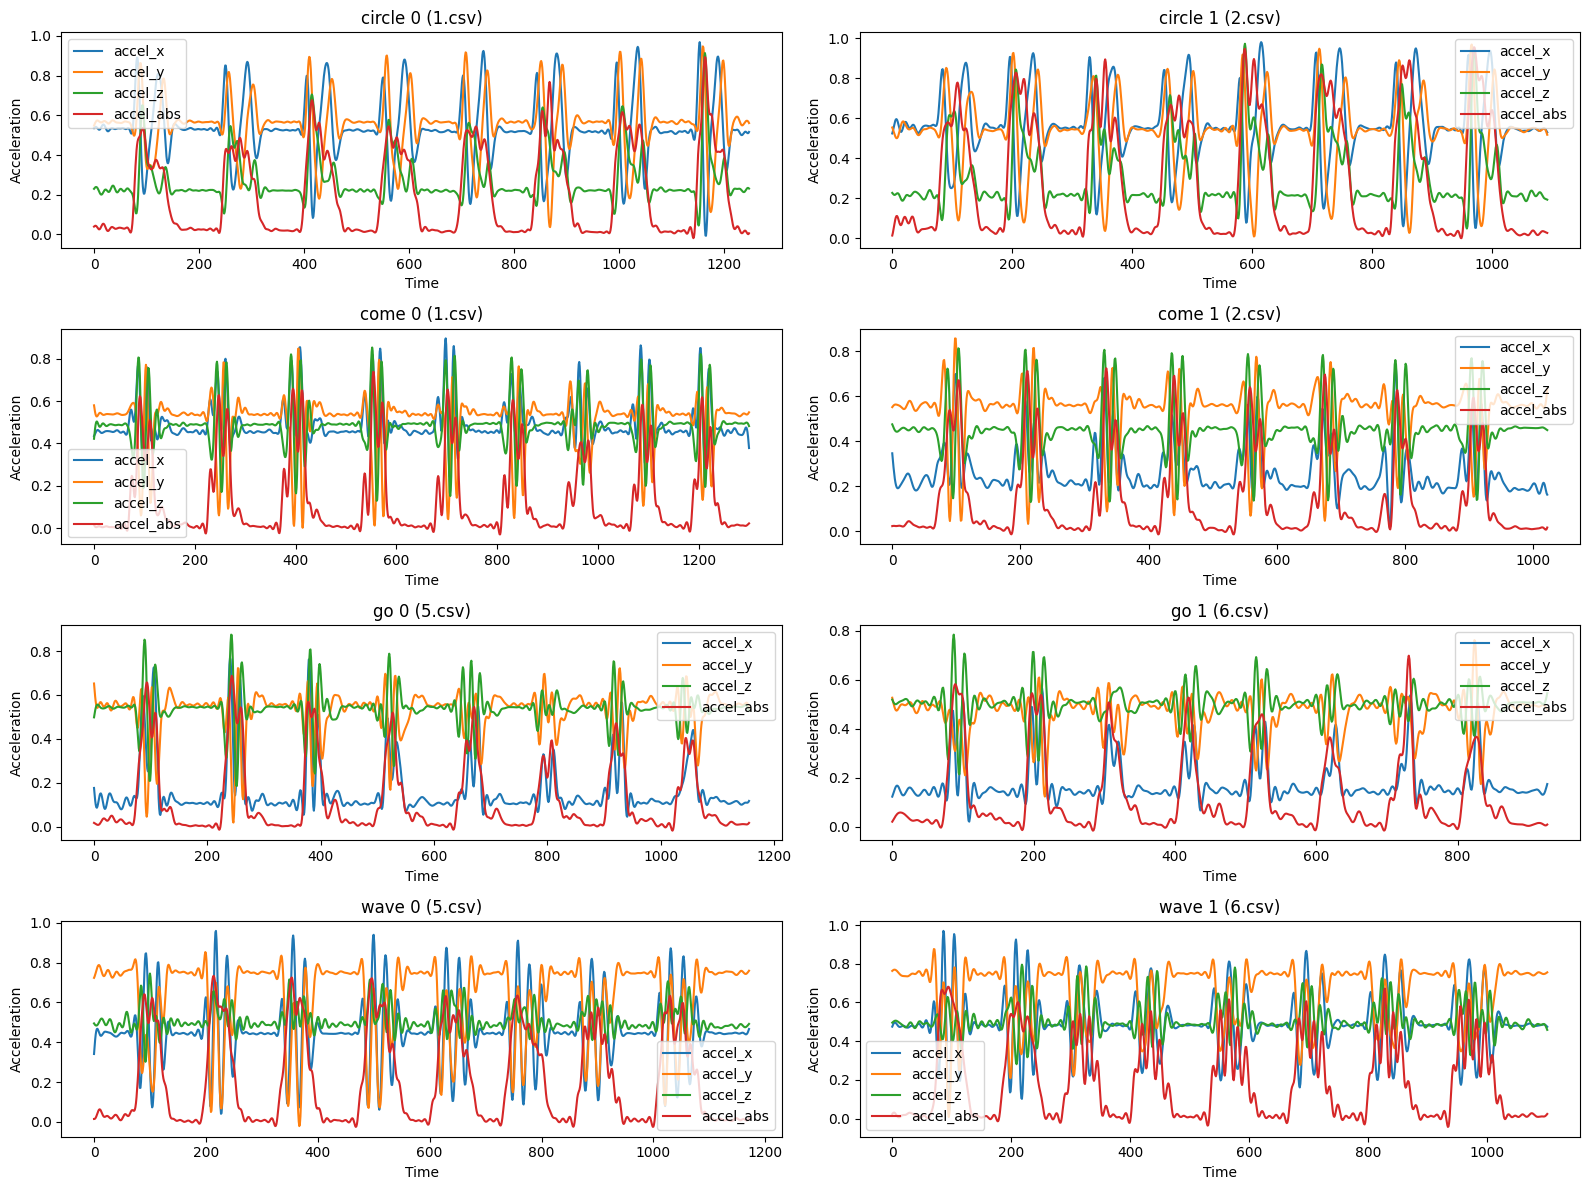

In [6]:
# Ashley Hunt - psyah10
import matplotlib.pyplot as plt

gestures = df['gesture'].unique()
file_numbers = df['file_number'].unique()[:2]

fig, axs = plt.subplots(4, 2, figsize=(16, 12))

for i, file_number in enumerate(file_numbers):
    for j, gesture in enumerate(gestures):
        sub_group = df[(df['gesture'] == gesture) & (df['file_number'] == file_number)].reset_index(drop=True)
        
        ax = axs[j, i]
        for col in get_columns()[1:]:
            ax.plot(sub_group.index, sub_group[col], label=col)
            ax.set_title("{gesture} {file_number} ({file_name})".format(gesture=gesture, file_number=file_number, file_name=sub_group['file_name'][0]))
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
            ax.legend()
        
plt.tight_layout()
plt.show()

We then try to segment this data, using the dips in acceleration that we had purposefully included in our data captures.

Firstly we visualise just one example to inspect the rolling standard deviation and attempt to find the optimal parameters for slicing our data.

In [7]:
rolling_window = 25
group_threshold = 10
deviation_threshold = 2.5

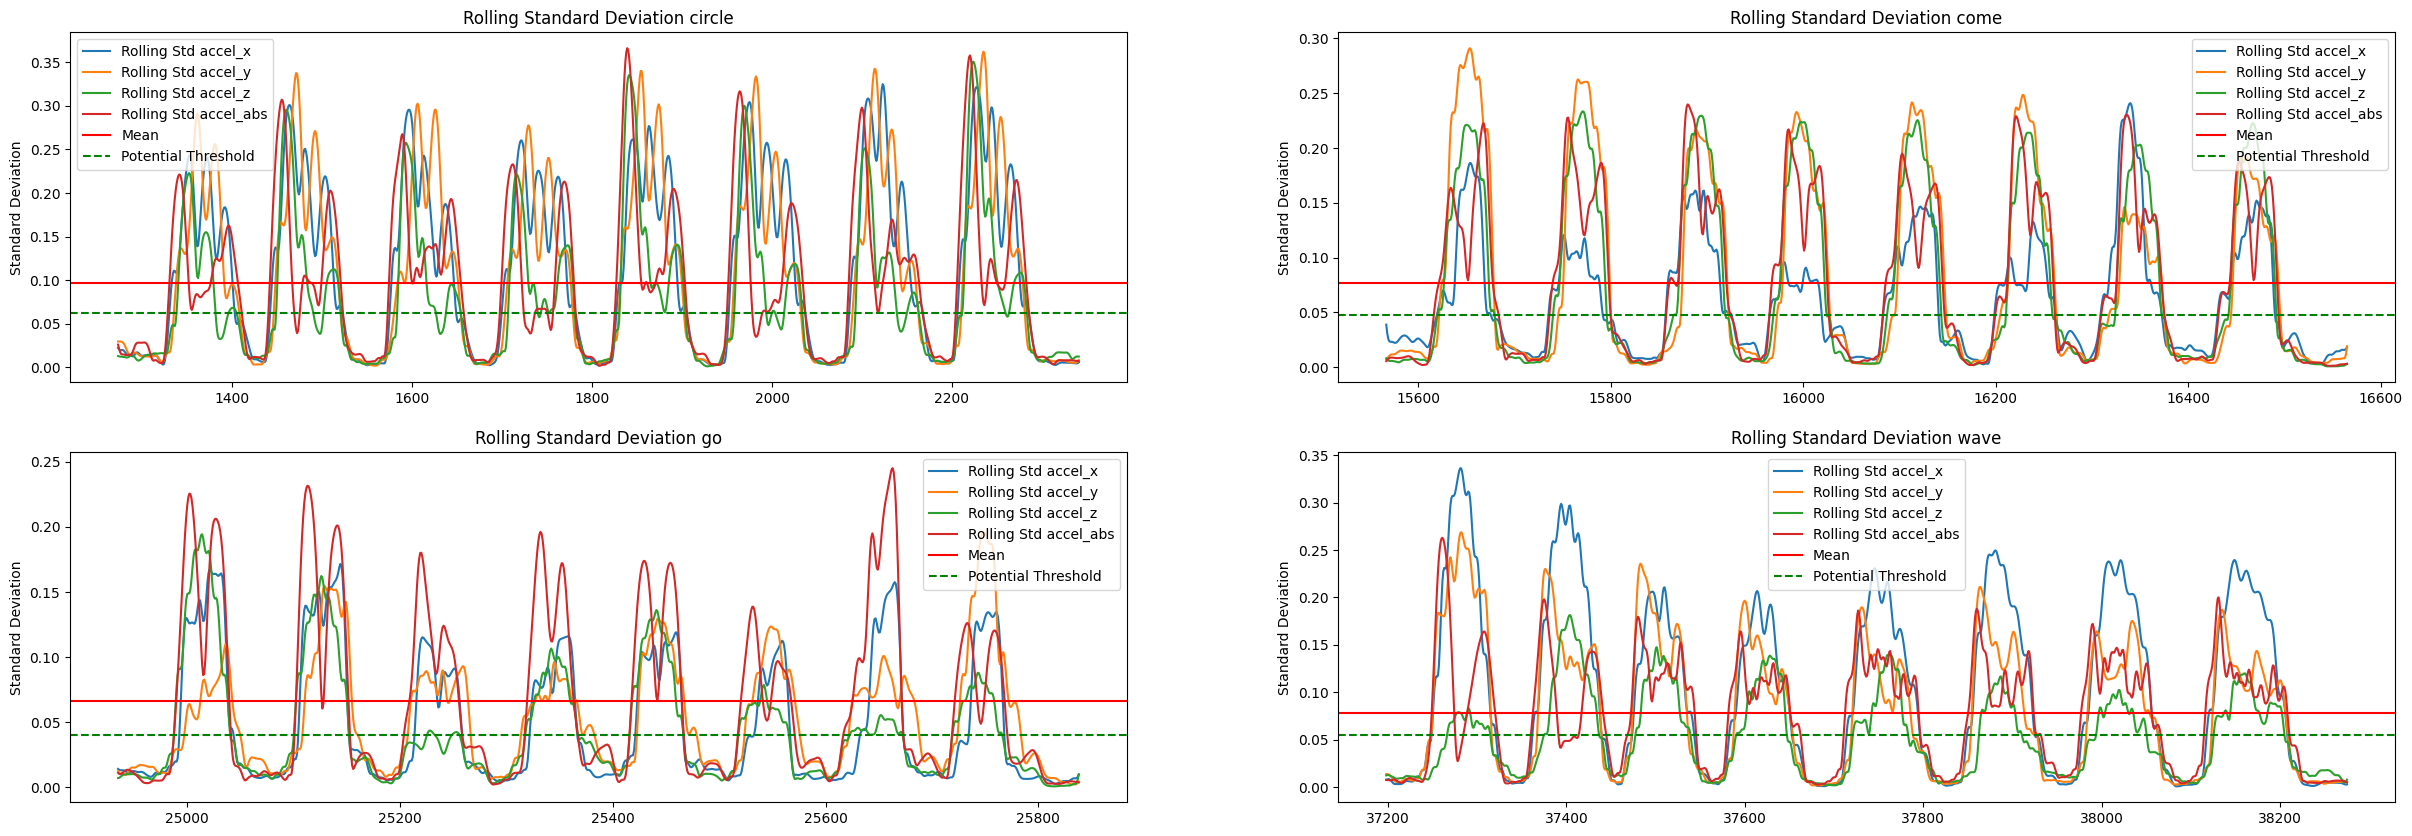

In [8]:
# Ashley Hunt - psyah10
plt.figure(figsize=(30, 10))

for file_index, gesture in enumerate(get_gestures()):

      group = df[(df['gesture'] == gesture) & (df['file_number'] == 1)]
      if len(group) == 0:
            continue

      rolling_std = group['accel_abs'].rolling(window=rolling_window).std()
      drop_if_all_below = rolling_std.mean() - rolling_std.std() / deviation_threshold

      plt.subplot(2, 2, file_index + 1)

      for col in get_columns()[1:]:
            plt.plot(group[col].rolling(window=rolling_window).std(), label=f'Rolling Std {col}')

      plt.axhline(y=rolling_std.mean(), color='r', linestyle='-', label='Mean')
      plt.axhline(y=drop_if_all_below, color='g', linestyle='--', label='Potential Threshold')    
      plt.title(f'Rolling Standard Deviation {gesture}')
      plt.ylabel('Standard Deviation')
      plt.legend()

plt.show()

In [9]:
# Ashley Hunt - psyah10

## Function to get the indices of the data points that are below the threshold
def get_indices_below_threshold(data, rolling_window, group_threshold, deviation_threshold):
      
      rolling_std = data['accel_abs'].rolling(window=rolling_window).std()
      threshold = rolling_std.mean() - rolling_std.std() / deviation_threshold

      return rolling_std[(rolling_std.shift(-group_threshold) < threshold) & (rolling_std.shift(group_threshold) < threshold)].index

## This function will merge the indices that are close to each other and return the average of the points
def cluster_and_average_points(integers, cluster_range=50):
      if(len(integers) == 0):
            return []
            
      clusters = []
      current_cluster = [integers[0]]

      for number in integers[1:]:
            if number - current_cluster[-1] <= cluster_range:
                  current_cluster.append(number)
            else:
                  clusters.append(current_cluster)
                  current_cluster = [number]
      
      if current_cluster:
            clusters.append(current_cluster)
      
      return [sum(cluster) // len(cluster) for cluster in clusters]

Then we visualise our slices for all of the data.

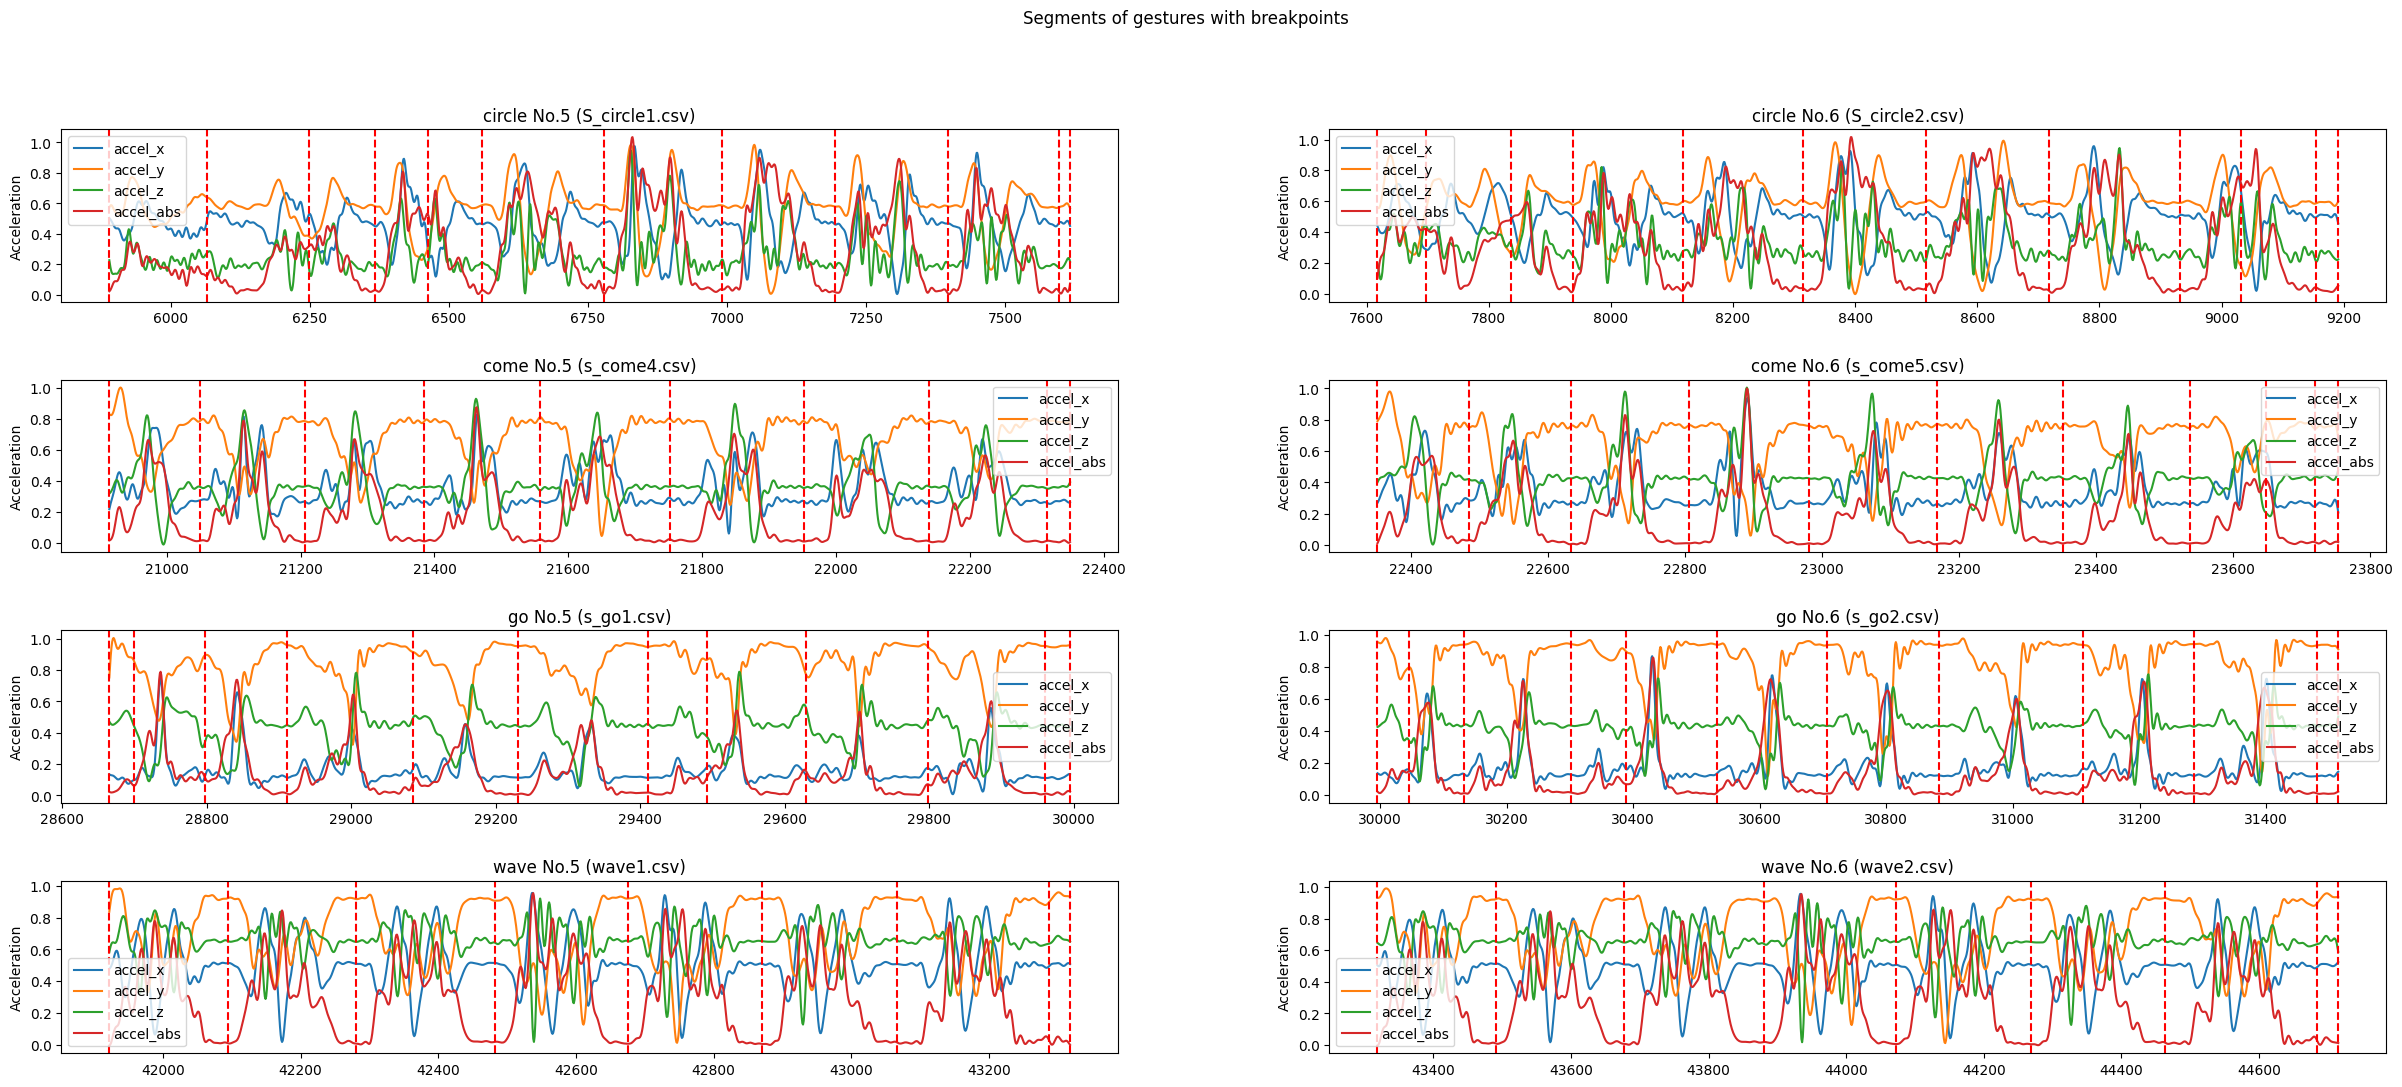

In [10]:
# Ashley Hunt - psyah10
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
        breakpoints = cluster_and_average_points(indices_below_threshold, 25)

        breakpoints.append(sub_group.index[0]) # Add the first index to the breakpoints
        breakpoints.append(sub_group.index[-1]) # Add the last index to the breakpoints

        if file_index < 5 or file_index > 6:
            continue

        plt.subplot(4, 2, plot)
        plot += 1

        for col in get_columns()[1:]:
            plt.plot(sub_group.index, sub_group[col], label=col)

        for index in breakpoints:
            plt.axvline(x=index, color='r', linestyle='--')

        file_name = sub_group['file_name'].iloc[0]
        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index} ({file_name})')
        plt.legend()
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We also visualise our test data splitting

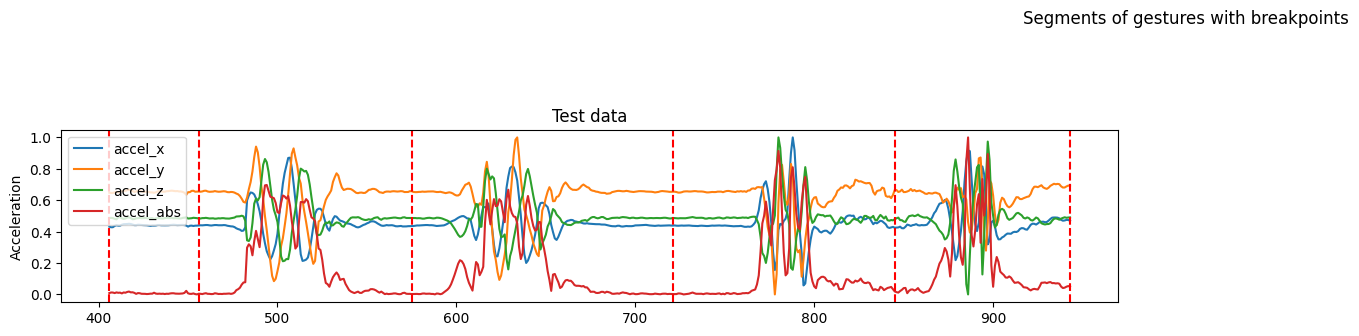

In [11]:
# Ashley Hunt - psyah10
plt.figure(figsize=(30, 12))
plot = 1

indices_below_threshold = get_indices_below_threshold(test_data, rolling_window, group_threshold, deviation_threshold)
breakpoints = cluster_and_average_points(indices_below_threshold, 25)
breakpoints.append(test_data.index[-1])
breakpoints.append(test_data.index[0])

plt.subplot(4, 2, plot)
plot += 1

for col in get_columns()[1:]:
      plt.plot(test_data.index, test_data[col], label=col)

for index in breakpoints:
      plt.axvline(x=index, color='r', linestyle='--')

plt.ylabel('Acceleration')
plt.title('Test data')
plt.legend()
plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We can safely remove the data where the absolute acceleration never gets above a certain threshold. Then split the data into those separate waves that represent each gesture.

In [12]:
# Ashley Hunt - psyah10
def segment_data(dataframe, sub_group, drop_all_below, short_segment_threshold):

      indices_to_drop = []

      indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
      breakpoints = cluster_and_average_points(indices_below_threshold, 25)

      breakpoints.insert(0, sub_group.index[0])
      breakpoints.append(sub_group.index[-1])

      for b in range(len(breakpoints) - 1):
            segment = dataframe.loc[breakpoints[b]:breakpoints[b + 1]]
            all_below_threshold = (segment['accel_abs'] < drop_all_below).all()
            if all_below_threshold or len(segment) < short_segment_threshold:
                  dropping = range(breakpoints[b], breakpoints[b + 1])
                  indices_to_drop += dropping
            else:
                  gesture_number = dataframe['gesture_number'].max() + 1 if 'gesture_number' in dataframe.columns else 0
                  if pd.isna(gesture_number):
                        gesture_number = 0
                  dataframe.loc[breakpoints[b]:breakpoints[b + 1], 'gesture_number'] = gesture_number
      return indices_to_drop

def drop_from(dataframe, indices_to_drop):
      dataframe.drop(indices_to_drop, inplace=True)
      dataframe.dropna(subset=['gesture_number'], inplace=True)
      dataframe.reset_index(drop=True, inplace=True)            

In [13]:
# Ashley Hunt - psyah10

## Apply segmentation and clearing of invalid gestures
drop_if_all_below = 0.3
short_segment_threshold = 50

indices_to_drop = []
for group_name, sub_group in df.groupby(['file_number', 'gesture']):
      idc = segment_data(df, sub_group, drop_if_all_below, short_segment_threshold)
      indices_to_drop += idc

drop_from(df, indices_to_drop)

## Do the same for the test data
t_indices_to_drop = segment_data(test_data, test_data, drop_if_all_below, short_segment_threshold)
drop_from(test_data, t_indices_to_drop)

In [14]:
# Ashley Hunt - psyah10
def number_to_color(number):    
    normalized_number = (number - 1) / (100 - 1)
    colormap = plt.cm.viridis
    color = colormap(normalized_number)
    
    return color

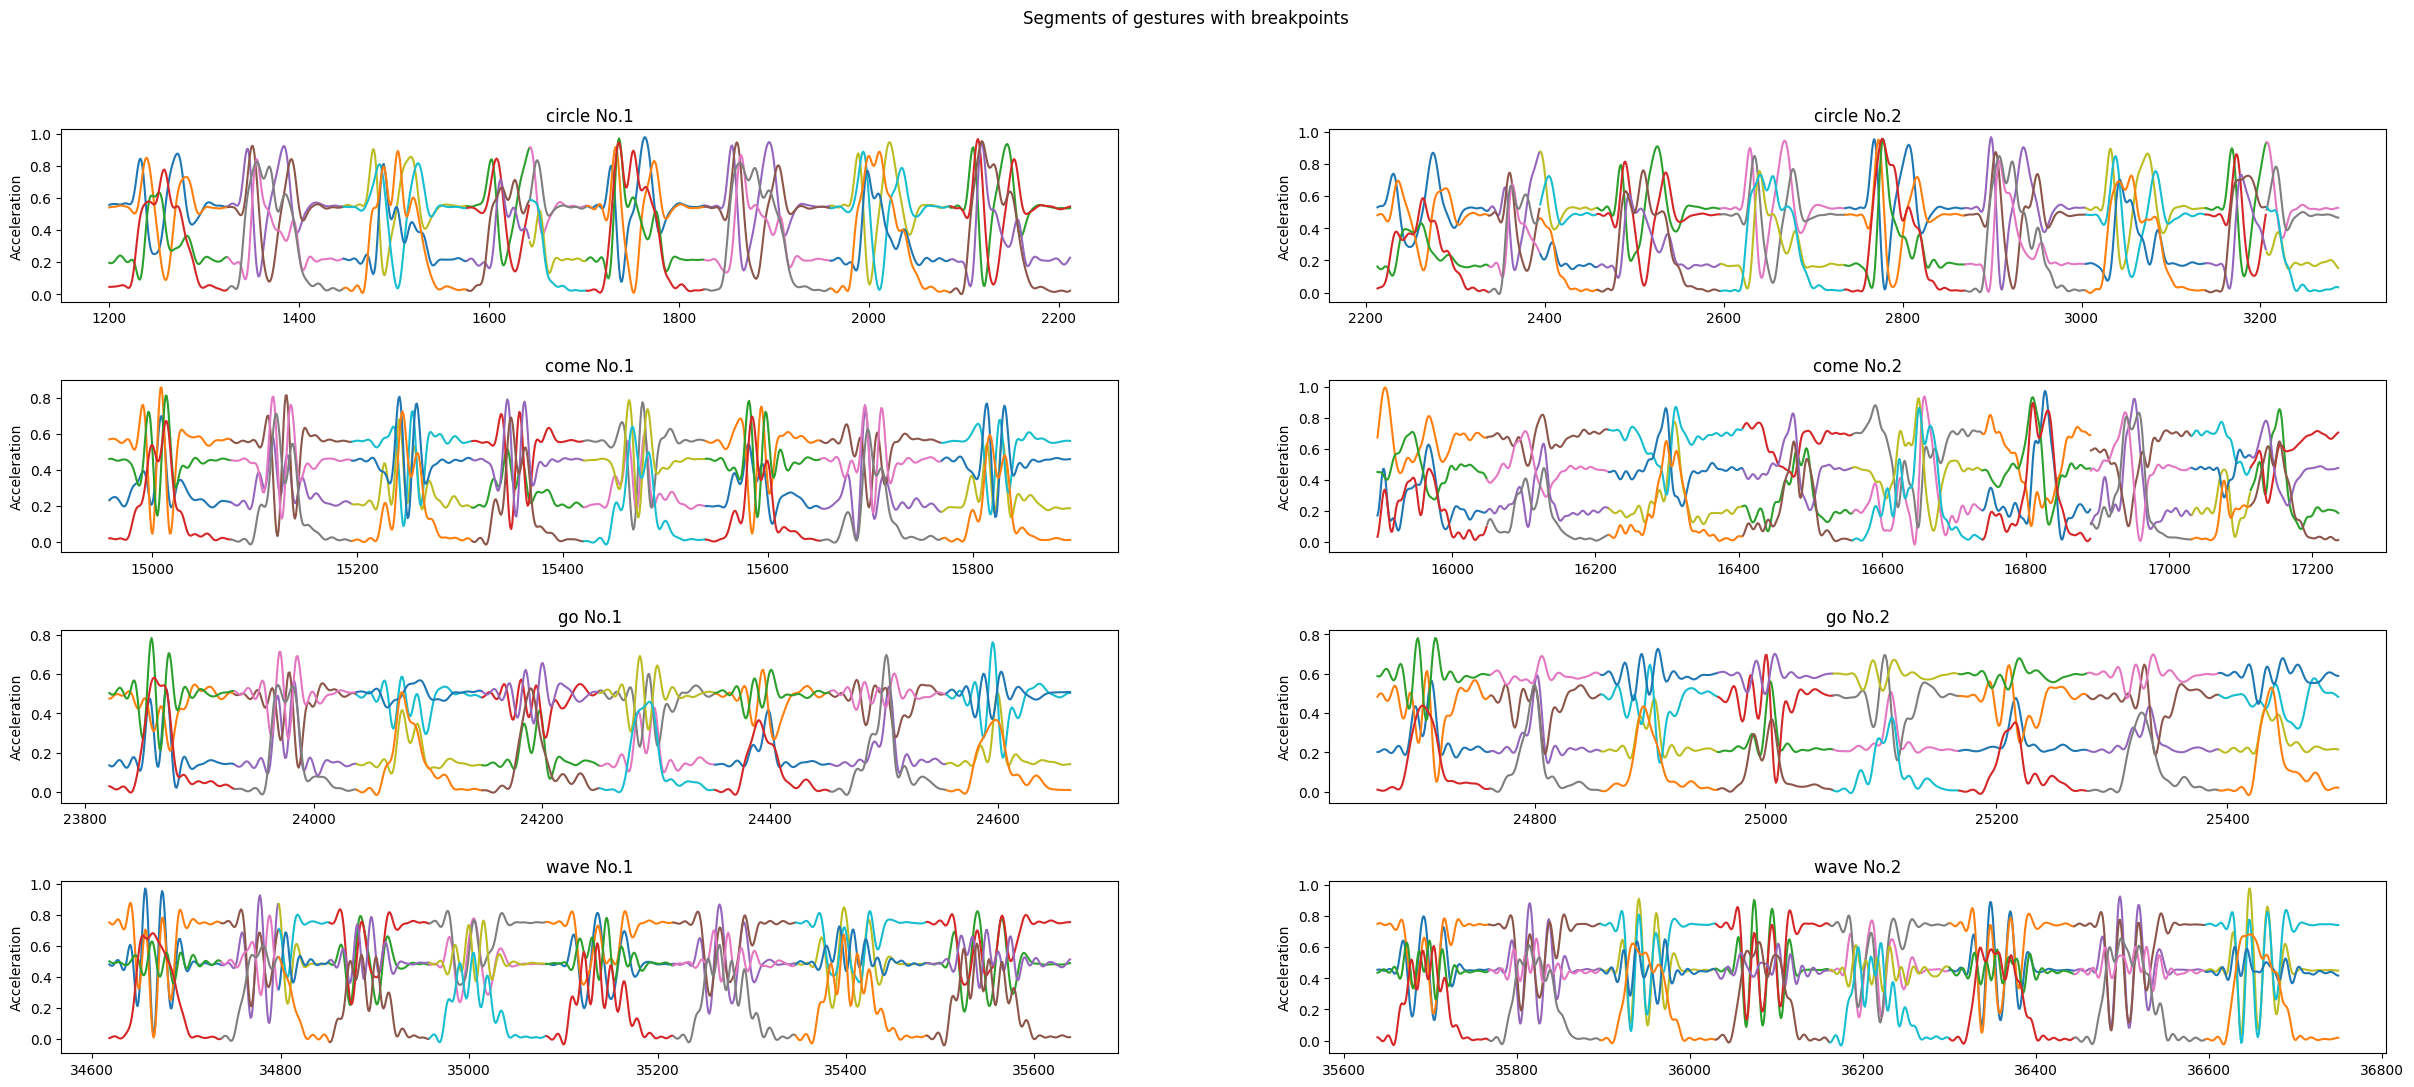

In [15]:
# Ashley Hunt - psyah10
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        if file_index < 1 or file_index > 2:
            continue

        plt.subplot(4, 2, plot)
        plot += 1

        for gesture_number in sub_group['gesture_number'].unique():
            gesture_group = sub_group[sub_group['gesture_number'] == gesture_number]        
        
            for col in get_columns()[1:]:
                plt.plot(gesture_group.index, gesture_group[col], label=number_to_color(gesture_number))

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index}')
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

Now we double check that the data does not contain these filtered out data segments that do not represent a gesture

In [16]:
# Ashley Hunt - psyah10
## Check we no longer have segments that are very short or have very low acceleration
for label, group in df.groupby(['gesture', 'gesture_number']):
      if(group.shape[0] < 50):
            sub_group = df[(df['gesture'] == label[0]) & (df['gesture_number'] == label[1])]
            print(label, group.shape[0], sub_group['file_number'].unique(), sub_group['gesture_number'].unique(), sub_group['accel_abs'].max())

Finally we can begin to extract our features for the models. These functions split the data into a fixed number of segments with some overlap and then take some key statistical values from these slices.

In [17]:
# Ashley Hunt - psyah10
def create_fixed_segments_df(data, num_segments, step_size):
    total_length = len(data)
    window_size = ((num_segments - 1) * step_size) + (total_length - (num_segments - 1) * step_size)

    segments = [data.iloc[i:i + window_size] for i in range(0, total_length - window_size + 1, step_size)]
    
    if len(segments) < num_segments:
        while len(segments) < num_segments and window_size > 0:
            window_size -= 1
            segments = [data.iloc[i:i + window_size] for i in range(0, total_length - window_size + 1, step_size)]
    
    return segments

def get_features_from_df(df, feature_functions, num_segments = 4, step_size = 10):
      results = []

      for _, data in df.groupby(['gesture_number']): # for each gesture in the data frame, extract features
            result_dict = {}

            if 'gesture' in data.columns:
                  result_dict['gesture'] = data['gesture'].iloc[0]
            
            segments = create_fixed_segments_df(data, num_segments, step_size)
            for n, segment in enumerate(segments):
                  for col in get_columns()[1:]:
                        for f in feature_functions:
                              result_dict[f'{col}_{f}_{n+1}'] = segment[col].agg(f)

            results.append(result_dict)

      return pd.DataFrame(results)

In [18]:
feature_functions = ['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis']
num_segments = 5
step_size = 10

In [19]:
# Ashley Hunt - psyah10
extracted_features = get_features_from_df(df, feature_functions, num_segments, step_size)
extracted_features

gesture  accel_x_mean_1  accel_x_std_1  accel_x_min_1  accel_x_max_1  \
0    circle        0.549330       0.159927       0.204750       0.891355   
1    circle        0.527033       0.009505       0.499406       0.549531   
2    circle        0.597323       0.166405       0.383827       0.869282   
3    circle        0.538180       0.177885       0.082958       0.863172   
4    circle        0.553001       0.072988       0.503335       0.772981   
..      ...             ...            ...            ...            ...   
314    wave        0.522517       0.172572       0.185132       0.834903   
315    wave        0.521587       0.177128       0.122270       0.841149   
316    wave        0.527190       0.189388       0.164707       0.915667   
317    wave        0.520485       0.192773       0.141687       0.951992   
318    wave        0.518475       0.169160       0.143944       0.875999   

     accel_x_median_1  accel_x_skew_1  accel_x_kurtosis_1  accel_y_mean_1  \
0            0.535437        0.056594           -0.152276        0.555008   
1            0.528799       -1.171594            2.653755        0.560788   
2            0.530195        0.387528           -1.355507        0.582475   
3            0.524399       -0.279761            0.375951        0.552144   
4            0.522504        2.080014            3.231929        0.552714   
..                ...             ...                 ...             ...   
314          0.516331        0.189894           -0.712012        0.579904   
315          0.518613        0.058738           -0.524432        0.514097   
316          0.521193        0.355132           -0.602628        0.497195   
317          0.510919        0.348322           -0.539565        0.431751   
318          0.514716        0.163816           -0.316655        0.525487   

     accel_y_std_1  ...  accel_z_median_5  accel_z_skew_5  accel_z_kurtosis_5  \
0         0.133317  ...          0.223479        2.194843            4.328203   
1         0.013772  ...          0.436656       -0.739218           -0.763199   
2         0.114710  ...          0.221195        1.892263            2.819012   
3         0.162426  ...          0.265136        1.513578            1.196663   
4         0.019329  ...          0.457684       -0.242620           -1.049567   
..             ...  ...               ...             ...                 ...   
314       0.227702  ...          0.607912       -1.303490            1.795908   
315       0.252662  ...          0.605024       -1.518061            1.916595   
316       0.289740  ...          0.590883       -0.640994            0.465774   
317       0.273590  ...          0.585928       -0.779134            1.887521   
318       0.277937  ...          0.598020       -0.924836            1.067373   

     accel_abs_mean_5  accel_abs_std_5  accel_abs_min_5  accel_abs_max_5  \
0            0.189990         0.173779         0.021805         0.536859   
1            0.411493         0.055298         0.206846         0.486980   
2            0.023248         0.005082         0.016772         0.040684   
3            0.249246         0.229179         0.012563         0.676246   
4            0.466954         0.043865         0.403994         0.544457   
..                ...              ...              ...              ...   
314          0.300994         0.215536         0.001592         0.722867   
315          0.318338         0.213600         0.009270         0.708206   
316          0.351035         0.230321         0.001620         0.767388   
317          0.331163         0.248715         0.003413         0.839677   
318          0.288407         0.222646         0.011192         0.685354   

     accel_abs_median_5  accel_abs_skew_5  accel_abs_kurtosis_5  
0              0.095252          0.483935             -1.290739  
1              0.419622         -1.836863              4.879722  
2              0.021812          1.341236              2.274091  
3              0

In [20]:
extracted_features.isna().sum()

gesture                 0
accel_x_mean_1          0
accel_x_std_1           0
accel_x_min_1           0
accel_x_max_1           0
                       ..
accel_abs_min_5         0
accel_abs_max_5         0
accel_abs_median_5      0
accel_abs_skew_5        0
accel_abs_kurtosis_5    0
Length: 141, dtype: int64

In [21]:
# Ashley Hunt - psyah10
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_labels(labels):
    return label_encoder.fit_transform(labels)

def decode_labels(encoded_labels):
    return label_encoder.inverse_transform(encoded_labels)

In [22]:
# Ashley Hunt - psyah10
from sklearn.model_selection import train_test_split

encoded_labels = encode_labels(extracted_features['gesture'])
features = extracted_features.loc[:, extracted_features.columns != 'gesture']

train_features, test_features, train_labels, test_labels = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [23]:
# Ashley Hunt - psyah10
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

rfc_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [24]:
# Ashley Hunt - psyah10
from sklearn.metrics import accuracy_score, classification_report

rfc_prediction = rfc_model.predict(test_features)
print(f"Accuracy: {accuracy_score(test_labels, rfc_prediction)}")
print(classification_report(test_labels, rfc_prediction))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        14

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



In [25]:
unseen_features = get_features_from_df(test_data, feature_functions, num_segments, step_size)
unseen_features

accel_x_mean_1  accel_x_std_1  accel_x_min_1  accel_x_max_1  \
0        0.467213       0.146782       0.213385       0.871035   
1        0.462713       0.113118       0.200429       0.814297   
2        0.455717       0.148515       0.057378       1.000000   
3        0.495833       0.146426       0.218263       0.917646   

   accel_x_median_1  accel_x_skew_1  accel_x_kurtosis_1  accel_y_mean_1  \
0          0.440685        0.697766            0.820017        0.581792   
1          0.449591        0.844283            2.448883        0.603391   
2          0.437769        0.909387            3.991274        0.588962   
3          0.444806        1.165330            1.559670        0.614454   

   accel_y_std_1  accel_y_min_1  ...  accel_z_median_5  accel_z_skew_5  \
0       0.201853       0.084575  ...          0.482793        0.534893   
1       0.164220       0.092489  ...          0.486523        0.559586   
2       0.158330       0.000000  ...          0.485543        0.989212   
3       0.103285       0.279139  ...          0.485983       -0.101977   

   accel_z_kurtosis_5  accel_abs_mean_5  accel_abs_std_5  accel_abs_min_5  \
0            1.841281          0.214079         0.243273         0.001471   
1            1.973777          0.179481         0.224071         0.001111   
2            4.457589          0.215152         0.250783         0.007514   
3            4.130583          0.205950         0.252332         0.025598   

   accel_abs_max_5  accel_abs_median_5  accel_abs_skew_5  accel_abs_kurtosis_5  
0         0.630156            0.072970          0.696000             -1.292733  
1         0.666752            0.052217          0.904730             -0.888439  
2         0.913786            0.085209          1.315716              0.366171  
3         1.000000            0.076428          1.718332              1.862280  

[4 rows x 140 columns]

In [26]:
results = rfc_model.predict(unseen_features)

print("Prediction on unseen data:", decode_labels(results))

Prediction on unseen data: ['wave' 'come' 'come' 'come']


In [27]:
# Ashley Hunt - psyah10
from sklearn import svm

svm_model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(train_features, train_labels)

SVC(kernel='linear')

In [28]:
svm_y_pred = svm_model.predict(test_features)

print(f"Accuracy: {accuracy_score(test_labels, svm_y_pred)}")
print(classification_report(test_labels, svm_y_pred))

Accuracy: 0.921875
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.88      0.93      0.90        15
           2       1.00      0.92      0.96        12
           3       0.87      0.93      0.90        14

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.92        64
weighted avg       0.93      0.92      0.92        64



In [29]:
# Ashley Hunt - psyah10
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [30]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(features, encoded_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.0000 degrees.
Accuracy = nan%.
Model Performance
Average Error: 0.0000 degrees.
Accuracy = nan%.
Improvement of nan%.


C:\Users\Ashley\AppData\Local\Temp\ipykernel_23440\336698329.py:4: RuntimeWarning: invalid value encountered in divide
  mape = 100 * np.mean(errors / test_labels)
C:\Users\Ashley\AppData\Local\Temp\ipykernel_23440\336698329.py:4: RuntimeWarning: invalid value encountered in divide
  mape = 100 * np.mean(errors / test_labels)


In [32]:
# Amit Kumar
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# for train_index, test_index in sss.split(features, encoded_labels):
#     train_features, test_features = features[train_index], features[test_index]
#     train_labels, test_labels = encoded_labels[train_index], encoded_labels[test_index]
#     print(f"  Test:  index={test_index}")
#     print(f"  Train: index={train_index}")
    
# rfc = RandomForestClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
 
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
# grid_search.fit(train_features, train_labels)

# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)

In [33]:
# Amit Kumar
# from xgboost import XGBClassifier
 
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
 
# for train_index, test_index in sss.split(X, y):
#     train_features, test_features = X[train_index], X[test_index]
#     train_labels, test_labels = y[train_index], y[test_index]
    
# xgb_classifier = XGBClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }
 
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
# grid_search.fit(train_features, train_labels)
 
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
 
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)